In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
from sklearn.cluster import KMeans

In [2]:
demand_seasonality_data = pd.read_csv('demand_seasonalities.csv')
metro_areas_data = pd.read_csv('msa.csv')
demand_pmf_by_zip_data = pd.read_csv('zip3_pmf.csv')
price_to_ship_in_zip_data = pd.read_csv('order_shipment_matrix.csv')
zip_coordinates_data = pd.read_csv('zip3_coordinates.csv')

In [3]:
price_to_ship_in_zip_data['minimum_distance'] = np.array([0,50,150,300,600,1000,1400,1800])
price_to_ship_in_zip_data['maximum_distance'] = np.array([50, 150,300,600,1000,1400,1800, 50000])
price_to_ship_in_zip_data['Zone'] = [z[0] for z in price_to_ship_in_zip_data['Zone'].astype('str')]
price_to_ship_in_zip_data

,Zone,Cost ($) per product unit,minimum_distance,maximum_distance
0,1,13.29,0,50
1,2,15.09,50,150
2,3,19.05,150,300
3,4,24.15,300,600
4,5,28.73,600,1000
5,6,34.00,1000,1400
6,7,36.17,1400,1800
7,8,38.81,1800,50000


In [4]:
df_coords_to_geo = gpd.GeoDataFrame(zip_coordinates_data, geometry= gpd.points_from_xy(zip_coordinates_data.Lon, zip_coordinates_data.Lat))
df_coords_to_geo

,ZIP3,Lat,Lon,geometry
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160)
1,11,42.105773,-72.583739,POINT (-72.58374 42.10577)
2,12,42.396595,-73.237576,POINT (-73.23758 42.39659)
3,13,42.578956,-72.540044,POINT (-72.54004 42.57896)
4,14,42.566233,-71.696724,POINT (-71.69672 42.56623)
...,...,...,...,...
887,995,60.970213,-151.140110,POINT (-151.14011 60.97021)
888,996,60.524385,-153.405946,POINT (-153.40595 60.52438)
889,997,65.359648,-151.894015,POINT (-151.89402 65.35965)
890,998,58.188334,-135.227811,POINT (-135.22781 58.18833)


In [5]:
world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

C:\Users\Arnav Ketkar\AppData\Local\Temp\ipykernel_23340\3432786234.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

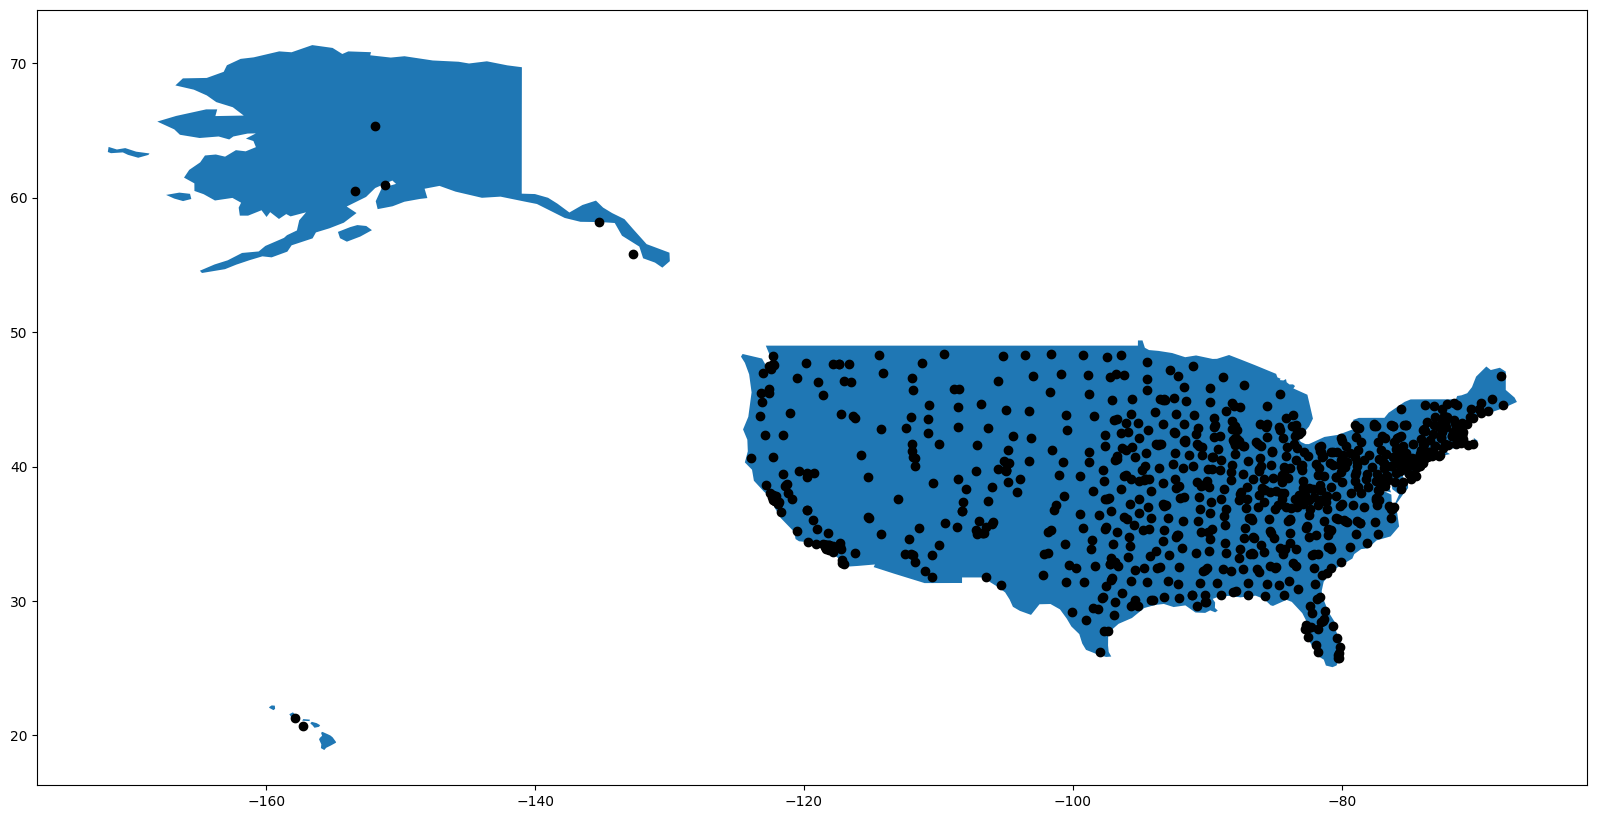

In [6]:
axis = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))
df_coords_to_geo.plot(ax=axis, color = 'black')

In [7]:
zip_coordinates_data.head()

,ZIP3,Lat,Lon
0,10,42.221598,-72.573558
1,11,42.105773,-72.583739
2,12,42.396595,-73.237576
3,13,42.578956,-72.540044
4,14,42.566233,-71.696724


In [8]:
FC_df = zip_coordinates_data.loc[zip_coordinates_data['ZIP3'].isin([303, 134, 799, 841])]
FC_df.head()

,ZIP3,Lat,Lon
113,134,43.104083,-75.332312
279,303,33.822421,-84.342545
728,799,31.765662,-106.448564
766,841,40.739511,-111.889378


In [9]:
c = FC_df.loc[:, ['Lat', 'Lon']]
c.values

array([[  43.10408259,  -75.33231194],
       [  33.82242118,  -84.34254523],
       [  31.7656623 , -106.4485636 ],
       [  40.73951069, -111.8893784 ]])

In [10]:
X = zip_coordinates_data.loc[:, ['Lat', 'Lon']]

In [11]:
id2fc = {id:zip for id, zip in enumerate([134, 303, 799, 841])}
id2fc

{0: 134, 1: 303, 2: 799, 3: 841}

In [12]:
import math
import haversine as hs
from haversine import Unit

def cluster_points(centers, data):
    new_data = pd.DataFrame(data, columns=['Lat', 'Lon'])
    #sorted_points = [[] for _ in range(4)]
    distances = []
    possible_FCs = [[] for _ in range(len(data))]
    for i, x in enumerate(data):
        dists = []
        for c in centers:
            dists.append(hs.haversine(c, x, unit=Unit.MILES))
        for j, d in enumerate(dists):
            if d<1500:
                possible_FCs[i].append(id2fc[j])
        #center_idx = np.argmin(dists)
        #print(dists)
        distances.append(dists)        
        #sorted_points.append(id2fc[center_idx])
    
    new_data['Possible_FCs'] = possible_FCs
    new_data['Distances'] = distances
    return new_data

clustered = cluster_points(c.values, X.values)

In [13]:
clustered

,Lat,Lon,Possible_FCs,Distances
0,42.221598,-72.573558,"[134, 303]","[152.84475432574433, 862.8421869061978, 1988.1..."
1,42.105773,-72.583739,"[134, 303]","[155.86124893391346, 857.4819639393293, 1986.2..."
2,42.396595,-73.237576,"[134, 303]","[116.97783794195817, 844.4320380110271, 1957.0..."
3,42.578956,-72.540044,"[134, 303]","[146.0324239207364, 879.7045337722267, 1994.28..."
4,42.566233,-71.696724,"[134, 303]","[187.89945882816684, 912.7848768692764, 2036.3..."
...,...,...,...,...
887,60.970213,-151.140110,[],"[3234.6798931405724, 3440.523293522389, 2839.4..."
888,60.524385,-153.405946,[],"[3316.534108861567, 3517.0050660922416, 2897.7..."
889,65.359648,-151.894015,[],"[3193.7461414594895, 3478.3367743900535, 2995...."
890,58.188334,-135.227811,[],"[2716.123767788193, 2865.4282278688743, 2269.0..."


So, Atlanta will deliver to 328 loactions; New York to 285 locations; Utah to 191 locations and Texas to 88 locations

In [14]:
df_geo = df_coords_to_geo.merge(clustered, how='left', on=['Lat', 'Lon'])
df_geo.head()

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160),"[134, 303]","[152.84475432574433, 862.8421869061978, 1988.1..."
1,11,42.105773,-72.583739,POINT (-72.58374 42.10577),"[134, 303]","[155.86124893391346, 857.4819639393293, 1986.2..."
2,12,42.396595,-73.237576,POINT (-73.23758 42.39659),"[134, 303]","[116.97783794195817, 844.4320380110271, 1957.0..."
3,13,42.578956,-72.540044,POINT (-72.54004 42.57896),"[134, 303]","[146.0324239207364, 879.7045337722267, 1994.28..."
4,14,42.566233,-71.696724,POINT (-71.69672 42.56623),"[134, 303]","[187.89945882816684, 912.7848768692764, 2036.3..."


In [15]:
FC_points = df_geo[df_geo.ZIP3.isin([134, 303, 799, 841])]
FC_points

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances
115,134,43.104083,-75.332312,POINT (-75.33231 43.10408),"[134, 303]","[0.0, 804.4805759332734, 1864.0958038961369, 1..."
281,303,33.822421,-84.342545,POINT (-84.34255 33.82242),"[134, 303, 799]","[804.4805759332734, 0.0, 1289.291613329621, 15..."
730,799,31.765662,-106.448564,POINT (-106.44856 31.76566),"[303, 799, 841]","[1864.0958038961369, 1289.291613329621, 0.0, 6..."
768,841,40.739511,-111.889378,POINT (-111.88938 40.73951),"[799, 841]","[1871.5431352024623, 1580.4453299309564, 689.8..."


In [16]:
'''c_dict = {134:'green', 303:'red', 799:'purple', 841:'orange'}
axis2 = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))
df_geo.plot(ax = axis2, c = [c_dict[cen] for cen in df_geo['Possible_FCs']])
FC_points.plot(ax=axis2, c='black', marker='*', markersize = 100)'''

"c_dict = {134:'green', 303:'red', 799:'purple', 841:'orange'}\naxis2 = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))\ndf_geo.plot(ax = axis2, c = [c_dict[cen] for cen in df_geo['Possible_FCs']])\nFC_points.plot(ax=axis2, c='black', marker='*', markersize = 100)"

In [17]:
df_geo.head()

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160),"[134, 303]","[152.84475432574433, 862.8421869061978, 1988.1..."
1,11,42.105773,-72.583739,POINT (-72.58374 42.10577),"[134, 303]","[155.86124893391346, 857.4819639393293, 1986.2..."
2,12,42.396595,-73.237576,POINT (-73.23758 42.39659),"[134, 303]","[116.97783794195817, 844.4320380110271, 1957.0..."
3,13,42.578956,-72.540044,POINT (-72.54004 42.57896),"[134, 303]","[146.0324239207364, 879.7045337722267, 1994.28..."
4,14,42.566233,-71.696724,POINT (-71.69672 42.56623),"[134, 303]","[187.89945882816684, 912.7848768692764, 2036.3..."


In [18]:
def lead_time(dists):
    lead_time = None
    if min(dists)<500:
        lead_time = 1
    elif min(dists)>=500 and min(dists)<1000:
        lead_time = 2
    elif min(dists)>=1000 and min(dists)<1500:
        lead_time = 3
    return lead_time

In [19]:
df_geo['LeadTime'] = df_geo['Distances'].apply(lead_time)

In [20]:
df_geo

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances,LeadTime
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160),"[134, 303]","[152.84475432574433, 862.8421869061978, 1988.1...",1.0
1,11,42.105773,-72.583739,POINT (-72.58374 42.10577),"[134, 303]","[155.86124893391346, 857.4819639393293, 1986.2...",1.0
2,12,42.396595,-73.237576,POINT (-73.23758 42.39659),"[134, 303]","[116.97783794195817, 844.4320380110271, 1957.0...",1.0
3,13,42.578956,-72.540044,POINT (-72.54004 42.57896),"[134, 303]","[146.0324239207364, 879.7045337722267, 1994.28...",1.0
4,14,42.566233,-71.696724,POINT (-71.69672 42.56623),"[134, 303]","[187.89945882816684, 912.7848768692764, 2036.3...",1.0
...,...,...,...,...,...,...,...
889,995,60.970213,-151.140110,POINT (-151.14011 60.97021),[],"[3234.6798931405724, 3440.523293522389, 2839.4...",NaN
890,996,60.524385,-153.405946,POINT (-153.40595 60.52438),[],"[3316.534108861567, 3517.0050660922416, 2897.7...",NaN
891,997,65.359648,-151.894015,POINT (-151.89402 65.35965),[],"[3193.7461414594895, 3478.3367743900535, 2995....",NaN
892,998,58.188334,-135.227811,POINT (-135.22781 58.18833),[],"[2716.123767788193, 2865.4282278688743, 2269.0...",NaN


In [21]:
df_geo['Possible_FCs'].value_counts()

Possible_FCs
[134, 303, 799, 841]    340
[134, 303]              272
[799, 841]              122
[134, 303, 799]          93
[303, 799, 841]          59
[]                        6
[134, 303, 841]           1
[841]                     1
Name: count, dtype: int64

In [22]:
np.unique(df_geo['Possible_FCs'])

array([list([]), list([134, 303]), list([134, 303, 799]),
       list([134, 303, 799, 841]), list([134, 303, 841]),
       list([303, 799, 841]), list([799, 841]), list([841])], dtype=object)

In [23]:
df_geos_with_regions = df_geo.copy()
for i in range(len(df_geos_with_regions)):
    for j, fcs in enumerate(np.unique(df_geo['Possible_FCs'])):
        if df_geos_with_regions.loc[i, 'Possible_FCs'] == fcs:
            df_geos_with_regions.loc[i, 'Regions'] = j

In [24]:
df_geos_with_regions['Regions'] = df_geos_with_regions['Regions'].astype('int')

In [25]:
df_geos_with_regions

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances,LeadTime,Regions
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160),"[134, 303]","[152.84475432574433, 862.8421869061978, 1988.1...",1.0,1
1,11,42.105773,-72.583739,POINT (-72.58374 42.10577),"[134, 303]","[155.86124893391346, 857.4819639393293, 1986.2...",1.0,1
2,12,42.396595,-73.237576,POINT (-73.23758 42.39659),"[134, 303]","[116.97783794195817, 844.4320380110271, 1957.0...",1.0,1
3,13,42.578956,-72.540044,POINT (-72.54004 42.57896),"[134, 303]","[146.0324239207364, 879.7045337722267, 1994.28...",1.0,1
4,14,42.566233,-71.696724,POINT (-71.69672 42.56623),"[134, 303]","[187.89945882816684, 912.7848768692764, 2036.3...",1.0,1
...,...,...,...,...,...,...,...,...
889,995,60.970213,-151.140110,POINT (-151.14011 60.97021),[],"[3234.6798931405724, 3440.523293522389, 2839.4...",NaN,0
890,996,60.524385,-153.405946,POINT (-153.40595 60.52438),[],"[3316.534108861567, 3517.0050660922416, 2897.7...",NaN,0
891,997,65.359648,-151.894015,POINT (-151.89402 65.35965),[],"[3193.7461414594895, 3478.3367743900535, 2995....",NaN,0
892,998,58.188334,-135.227811,POINT (-135.22781 58.18833),[],"[2716.123767788193, 2865.4282278688743, 2269.0...",NaN,0


In [26]:
df_geos_with_regions.drop(df_geos_with_regions[df_geos_with_regions['Regions'] == 0].index, inplace=True)
df_geos_with_regions.Regions.value_counts()

Regions
3    340
1    272
6    122
2     93
5     59
4      1
7      1
Name: count, dtype: int64

In [27]:
colors = ['purple', 'black', 'green', 'cyan', 'pink', 'yellow', 'olive']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: >

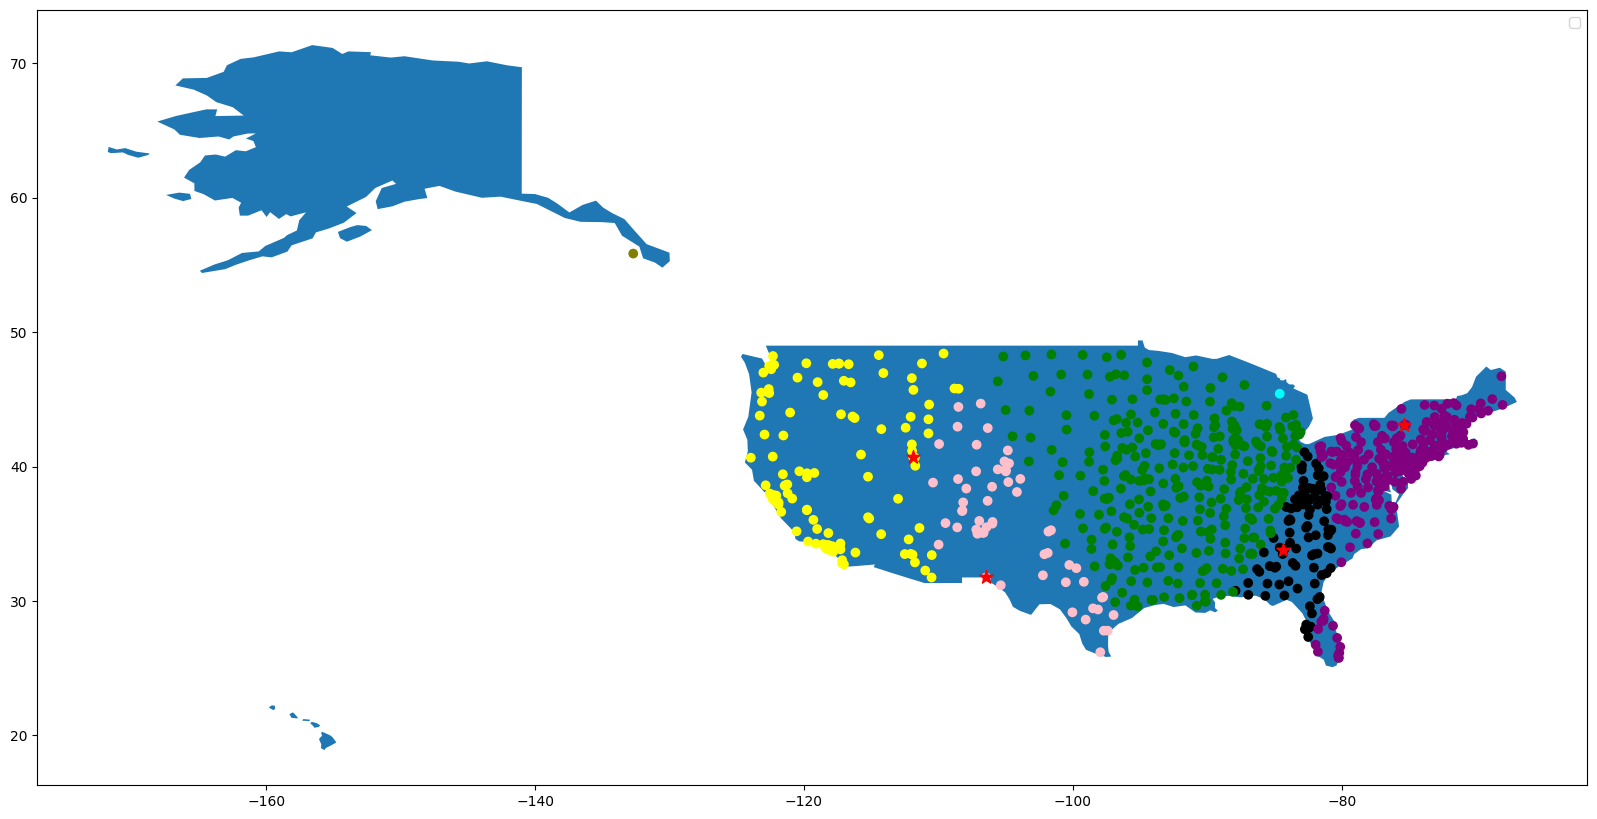

In [28]:
axis3 = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))
df_geos_with_regions.plot(ax = axis3, c = [colors[reg-1] for reg in df_geos_with_regions['Regions']], legend=True)
plt.legend()
FC_points.plot(ax=axis3, c='red', marker='*', markersize = 100)

In [29]:
df_geos_with_regions_exploded = df_geos_with_regions.explode(column='Possible_FCs', ignore_index=True)
df_geos_with_regions_exploded

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances,LeadTime,Regions
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160),134,"[152.84475432574433, 862.8421869061978, 1988.1...",1.0,1
1,10,42.221598,-72.573558,POINT (-72.57356 42.22160),303,"[152.84475432574433, 862.8421869061978, 1988.1...",1.0,1
2,11,42.105773,-72.583739,POINT (-72.58374 42.10577),134,"[155.86124893391346, 857.4819639393293, 1986.2...",1.0,1
3,11,42.105773,-72.583739,POINT (-72.58374 42.10577),303,"[155.86124893391346, 857.4819639393293, 1986.2...",1.0,1
4,12,42.396595,-73.237576,POINT (-73.23758 42.39659),134,"[116.97783794195817, 844.4320380110271, 1957.0...",1.0,1
...,...,...,...,...,...,...,...,...
2603,993,46.284993,-118.983570,POINT (-118.98357 46.28499),799,"[2127.9544816559946, 2003.3573102348687, 1204....",2.0,6
2604,993,46.284993,-118.983570,POINT (-118.98357 46.28499),841,"[2127.9544816559946, 2003.3573102348687, 1204....",2.0,6
2605,994,46.385250,-117.035920,POINT (-117.03592 46.38525),799,"[2035.1861215855918, 1914.9504771216746, 1156....",1.0,6
2606,994,46.385250,-117.035920,POINT (-117.03592 46.38525),841,"[2035.1861215855918, 1914.9504771216746, 1156....",1.0,6


In [30]:
FC_points

,ZIP3,Lat,Lon,geometry,Possible_FCs,Distances
115,134,43.104083,-75.332312,POINT (-75.33231 43.10408),"[134, 303]","[0.0, 804.4805759332734, 1864.0958038961369, 1..."
281,303,33.822421,-84.342545,POINT (-84.34255 33.82242),"[134, 303, 799]","[804.4805759332734, 0.0, 1289.291613329621, 15..."
730,799,31.765662,-106.448564,POINT (-106.44856 31.76566),"[303, 799, 841]","[1864.0958038961369, 1289.291613329621, 0.0, 6..."
768,841,40.739511,-111.889378,POINT (-111.88938 40.73951),"[799, 841]","[1871.5431352024623, 1580.4453299309564, 689.8..."


In [34]:
FC_points = FC_points.drop('Possible_FCs', axis = 1)
FC_points

,ZIP3,Lat,Lon,geometry,Distances
115,134,43.104083,-75.332312,POINT (-75.33231 43.10408),"[0.0, 804.4805759332734, 1864.0958038961369, 1..."
281,303,33.822421,-84.342545,POINT (-84.34255 33.82242),"[804.4805759332734, 0.0, 1289.291613329621, 15..."
730,799,31.765662,-106.448564,POINT (-106.44856 31.76566),"[1864.0958038961369, 1289.291613329621, 0.0, 6..."
768,841,40.739511,-111.889378,POINT (-111.88938 40.73951),"[1871.5431352024623, 1580.4453299309564, 689.8..."


In [50]:
from shapely.geometry import LineString
df_lines = pd.merge(FC_points, df_geos_with_regions_exploded, how='cross')
df_lines = df_lines[df_lines['Possible_FCs'] == df_lines['ZIP3_x']]
df_lines = df_lines.reset_index()
df_lines['Distance'] = 0.0

,index,ZIP3_x,Lat_x,Lon_x,geometry_x,Distances_x,ZIP3_y,Lat_y,Lon_y,geometry_y,Possible_FCs,Distances_y,LeadTime,Regions,Distance
0,0,134,43.104083,-75.332312,POINT (-75.33231 43.10408),"[0.0, 804.4805759332734, 1864.0958038961369, 1...",10,42.221598,-72.573558,POINT (-72.57356 42.22160),134,"[152.84475432574433, 862.8421869061978, 1988.1...",1.0,1,0.0
1,2,134,43.104083,-75.332312,POINT (-75.33231 43.10408),"[0.0, 804.4805759332734, 1864.0958038961369, 1...",11,42.105773,-72.583739,POINT (-72.58374 42.10577),134,"[155.86124893391346, 857.4819639393293, 1986.2...",1.0,1,0.0
2,4,134,43.104083,-75.332312,POINT (-75.33231 43.10408),"[0.0, 804.4805759332734, 1864.0958038961369, 1...",12,42.396595,-73.237576,POINT (-73.23758 42.39659),134,"[116.97783794195817, 844.4320380110271, 1957.0...",1.0,1,0.0
3,6,134,43.104083,-75.332312,POINT (-75.33231 43.10408),"[0.0, 804.4805759332734, 1864.0958038961369, 1...",13,42.578956,-72.540044,POINT (-72.54004 42.57896),134,"[146.0324239207364, 879.7045337722267, 1994.28...",1.0,1,0.0
4,8,134,43.104083,-75.332312,POINT (-75.33231 43.10408),"[0.0, 804.4805759332734, 1864.0958038961369, 1...",14,42.566233,-71.696724,POINT (-71.69672 42.56623),134,"[187.89945882816684, 912.7848768692764, 2036.3...",1.0,1,0.0


In [51]:
for i in range(len(df_lines)):
    point1 = (df_lines.loc[i, 'Lat_x'], df_lines.loc[i, 'Lon_x'])
    point2 = (df_lines.loc[i, 'Lat_y'], df_lines.loc[i, 'Lon_y'])
    df_lines.loc[i, 'Distance'] = hs.haversine(point1, point2, unit='mi')

In [54]:
df_lines = df_lines[['ZIP3_x', 'geometry_x', 'ZIP3_y', 'geometry_y', 'LeadTime', 'Distance']]
df_lines['Lines'] = df_lines.apply(lambda x: LineString([x['geometry_x'], x['geometry_y']]), axis=1)
df_lines.head()

,ZIP3_x,geometry_x,ZIP3_y,geometry_y,LeadTime,Distance,Lines
0,134,POINT (-75.33231 43.10408),10,POINT (-72.57356 42.22160),1.0,152.844754,"LINESTRING (-75.33231 43.10408, -72.57356 42.2..."
1,134,POINT (-75.33231 43.10408),11,POINT (-72.58374 42.10577),1.0,155.861249,"LINESTRING (-75.33231 43.10408, -72.58374 42.1..."
2,134,POINT (-75.33231 43.10408),12,POINT (-73.23758 42.39659),1.0,116.977838,"LINESTRING (-75.33231 43.10408, -73.23758 42.3..."
3,134,POINT (-75.33231 43.10408),13,POINT (-72.54004 42.57896),1.0,146.032424,"LINESTRING (-75.33231 43.10408, -72.54004 42.5..."
4,134,POINT (-75.33231 43.10408),14,POINT (-71.69672 42.56623),1.0,187.899459,"LINESTRING (-75.33231 43.10408, -71.69672 42.5..."


In [55]:
price_to_ship_in_zip_data

,Zone,Cost ($) per product unit,minimum_distance,maximum_distance
0,1,13.29,0,50
1,2,15.09,50,150
2,3,19.05,150,300
3,4,24.15,300,600
4,5,28.73,600,1000
5,6,34.00,1000,1400
6,7,36.17,1400,1800
7,8,38.81,1800,50000


In [56]:
def get_cost(dist):
    cost = 0.0
    for j in range(len(price_to_ship_in_zip_data)):
        if dist > price_to_ship_in_zip_data.loc[j, 'minimum_distance'] and dist <= price_to_ship_in_zip_data.loc[j, 'maximum_distance']:
            cost = price_to_ship_in_zip_data.loc[j, 'Cost ($) per product unit']
            break
    return cost

In [57]:
df_lines['Cost'] = df_lines['Distance'].apply(get_cost)
df_lines

,ZIP3_x,geometry_x,ZIP3_y,geometry_y,LeadTime,Distance,Lines,Cost
0,134,POINT (-75.33231 43.10408),10,POINT (-72.57356 42.22160),1.0,152.844754,"LINESTRING (-75.33231 43.10408, -72.57356 42.2...",19.05
1,134,POINT (-75.33231 43.10408),11,POINT (-72.58374 42.10577),1.0,155.861249,"LINESTRING (-75.33231 43.10408, -72.58374 42.1...",19.05
2,134,POINT (-75.33231 43.10408),12,POINT (-73.23758 42.39659),1.0,116.977838,"LINESTRING (-75.33231 43.10408, -73.23758 42.3...",15.09
3,134,POINT (-75.33231 43.10408),13,POINT (-72.54004 42.57896),1.0,146.032424,"LINESTRING (-75.33231 43.10408, -72.54004 42.5...",15.09
4,134,POINT (-75.33231 43.10408),14,POINT (-71.69672 42.56623),1.0,187.899459,"LINESTRING (-75.33231 43.10408, -71.69672 42.5...",19.05
...,...,...,...,...,...,...,...,...
2603,841,POINT (-111.88938 40.73951),991,POINT (-117.86336 47.64105),2.0,560.834467,"LINESTRING (-111.88938 40.73951, -117.86336 47...",24.15
2604,841,POINT (-111.88938 40.73951),992,POINT (-117.39643 47.66157),2.0,550.250928,"LINESTRING (-111.88938 40.73951, -117.39643 47...",24.15
2605,841,POINT (-111.88938 40.73951),993,POINT (-118.98357 46.28499),2.0,522.237282,"LINESTRING (-111.88938 40.73951, -118.98357 46...",24.15
2606,841,POINT (-111.88938 40.73951),994,POINT (-117.03592 46.38525),1.0,467.267063,"LINESTRING (-111.88938 40.73951, -117.03592 46...",24.15


In [63]:
df_lines = df_lines.set_geometry('Lines')
df_lines['LeadTime'] = df_lines['LeadTime'].apply(int)

In [61]:
ltc = {1: 'green', 2: 'yellow', 3: 'orange'}

<Axes: >

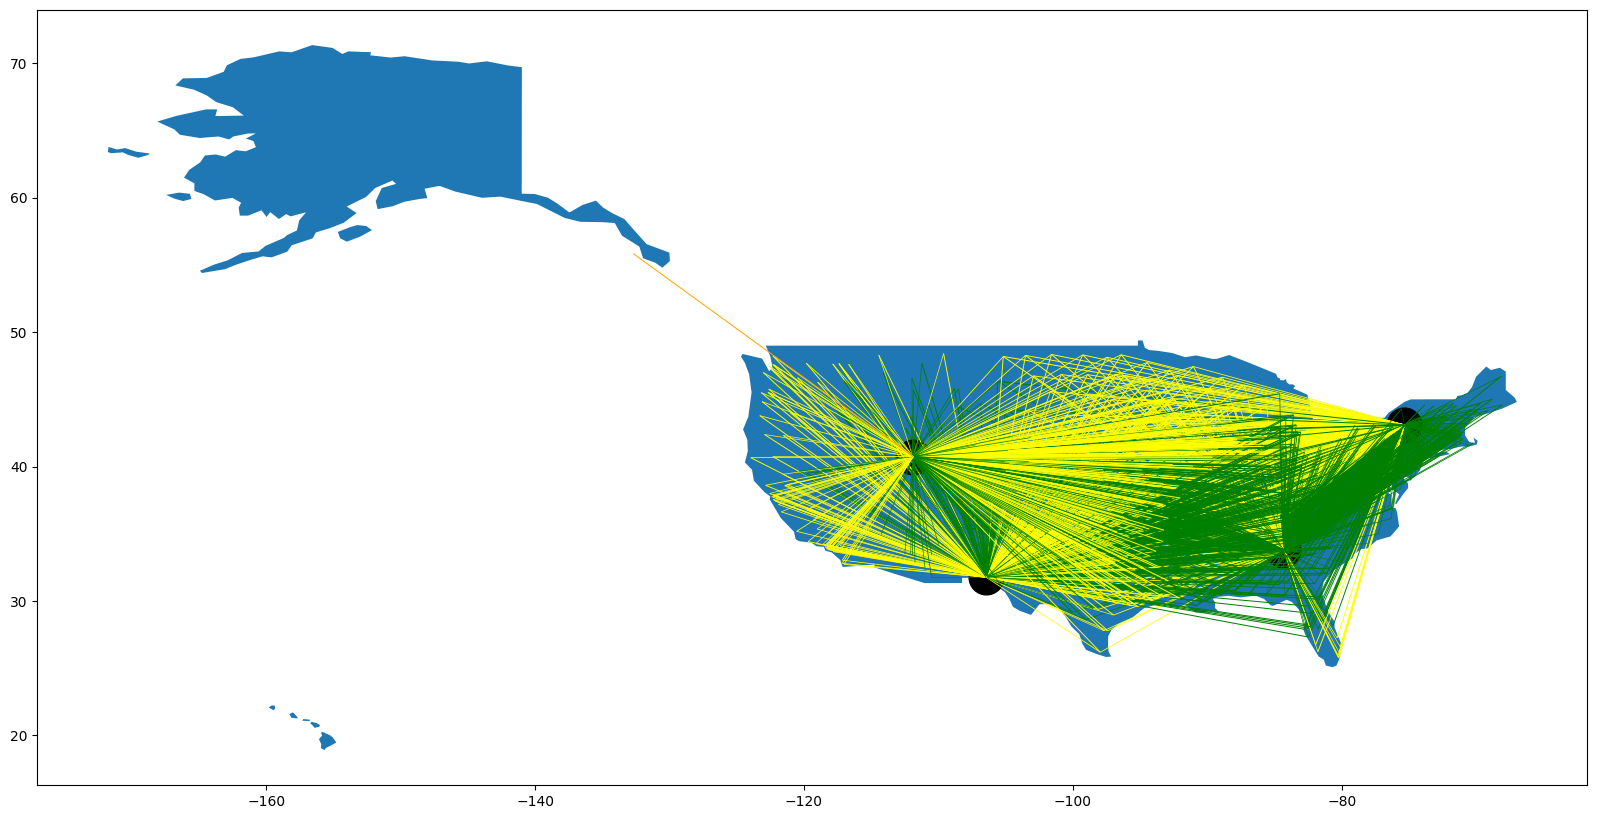

In [74]:
axis4 = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))
df_lines.plot(ax = axis4, color=[ltc[lt] for lt in df_lines['LeadTime']], linewidth=df_lines['Cost']/50)
FC_points.plot(ax=axis4, c='black', marker='.', markersize =2500)